In [1]:
import os
import re
import random
import json
from typing import List


import numpy as np
import tensorflow as tf

tf.enable_eager_execution()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.InteractiveSession(config=config)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
def make_filter_function(min_year: int, allow_retweets: bool):
    def include_function(record: dict):
        retweeted = record['retweeted']
        year = int(record['created_at'][-4:])
        if retweeted == allow_retweets and year >= min_year:
            return True
        else:
            return False
    return include_function


def get_tweets(filepath: str, filter_function, return_text_only=True):
    tweet_list = list()
    with open(filepath, 'r') as tweets:
        for tweet in tweets:
            tweet_record = json.loads(tweet)
            if filter_function(tweet_record):
                if return_text_only:
                    tweet_list.append(tweet_record['text'])
                else:
                    tweet_list.append(tweet_record)
    return tweet_list


include_lambda = make_filter_function(min_year=2015, allow_retweets=False)
TWEET_PATH = 'trump_tweets.json'
tweet_data = get_tweets(filepath=TWEET_PATH, filter_function=include_lambda, return_text_only=True)

In [3]:
tweet_data[:10]

['"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"',
 '"@teamconquerca: First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality',
 '"@AngelaTN777: @gochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"',
 '"@JaayZen: @grandmiapens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"',
 '"@MarcAardvark: @realDonaldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"',
 '"@PaulParmar1: @realDonaldTrump so excited for @ApprenticeNBC thank you for creating such an amazing show #CelebApprentice" Enjoy it, thanks',
 '"@ryanbushby: @realDonaldTrump i bet you have some great ideas on how to turn this country around"  I do, big league!',
 '"@LLAnkers: DonaldTrump,  it\'s a shame the l

In [4]:
# Remove URLs
tweet_data = [
    re.sub('http\S+', '', tweet, flags=re.MULTILINE)
    for tweet in tweet_data
]

In [5]:
tweet_data[:10]

['"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"',
 '"@teamconquerca: First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality',
 '"@AngelaTN777: @gochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"',
 '"@JaayZen: @grandmiapens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"',
 '"@MarcAardvark: @realDonaldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"',
 '"@PaulParmar1: @realDonaldTrump so excited for @ApprenticeNBC thank you for creating such an amazing show #CelebApprentice" Enjoy it, thanks',
 '"@ryanbushby: @realDonaldTrump i bet you have some great ideas on how to turn this country around"  I do, big league!',
 '"@LLAnkers: DonaldTrump,  it\'s a shame the l

In [6]:
tweet_text = '\n'.join(tweet_data)

In [7]:
vocab = sorted(set(tweet_text))

In [8]:
token_to_index = {u:i for i, u in enumerate(vocab)}
index_to_token = np.array(vocab)

In [9]:
word_count = len(index_to_token)
print(
  f'[+] {word_count} Distinct Tokens in The Donald\'s tweets'
)

[+] 566 Distinct Tokens in The Donald's tweets


In [10]:
def pretty_print_dict(d: dict, length=20):
    print('{')
    for (index, (k, v)) in zip(range(length), d.items()):
        print(f'\t{k}: {v}')
    print('...')
    print('}')

print('[+] Token to Index:')
pretty_print_dict(token_to_index, 20)
print(f'[+] Index to Token:')
print(index_to_token)

[+] Token to Index:
{
	
: 0
	 : 1
	!: 2
	": 3
	#: 4
	$: 5
	%: 6
	&: 7
	': 8
	(: 9
	): 10
	*: 11
	+: 12
	,: 13
	-: 14
	.: 15
	/: 16
	0: 17
	1: 18
	2: 19
...
}
[+] Index to Token:
['\n' ' ' '!' '"' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0'
 '1' '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '=' '?' '@' 'A' 'B' 'C' 'D'
 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V'
 'W' 'X' 'Y' 'Z' '[' '\\' ']' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i'
 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '{'
 '|' '}' '~' '\xa0' '«' '¯' '´' '»' 'É' 'á' 'â' 'è' 'é' 'í' 'ï' 'ñ' 'ó'
 'ô' 'ø' 'ú' 'ğ' 'ı' 'ĺ' 'ō' 'ד' 'ז' 'ח' 'י' 'ם' 'מ' 'ק' 'ת' 'ا' 'ب' 'ت'
 'ج' 'د' 'ر' 'س' 'ش' 'ط' 'ف' 'ق' 'ل' 'م' 'ن' 'ه' 'و' 'چ' 'ژ' 'ک' 'ی' '۰'
 '۴' 'ễ' '\u200b' '\u200d' '–' '—' '―' '‘' '’' '“' '”' '•' '…' '′' '‼'
 '\u2066' '\u2069' '↔' '●' '☀' '☁' '☆' '☉' '☑' '☘' '☞' '☹' '☺' '♂' '♡' '♥'
 '⚠' '⚡' '⚾' '✅' '✈' '✌' '✔' '✨' '❌' '❤' '➜' '➡' '⬅' '⬇' '、' '。' '々' '《'
 '「' '」' '【' '】' '

In [11]:
text_as_int = np.array([token_to_index[c] for c in tweet_text])

In [12]:
# Here we are just getting the really long sequence into
# tf.Dataset object. 
SEQUENCE_LENGTH = 140
examples_per_epoch = len(tweet_text) // SEQUENCE_LENGTH

sequence_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
print('First 5 Tokens:')
for i in sequence_dataset.take(5):
    print(index_to_token[i.numpy()])

First 5 Tokens:
Instructions for updating:
Colocations handled automatically by placer.
"
@
J
a
a


In [13]:
sequences = sequence_dataset.batch(SEQUENCE_LENGTH + 1, drop_remainder=True)


for item in sequences.take(5):
    print(repr(''.join(index_to_token[item.numpy()])))

'"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca:'
' First time in the"Trump International Hotel and Tower" and it\'s absolutely gorgeous!! Thank-You sir! Excellent hospitality\n"@AngelaTN777: @g'
'ochico @realDonaldTrump: He STANDS UP for what he believes in!! regardless if all people like it. #Hasmyrespect&amp;Vote"\n"@JaayZen: @grandmi'
'apens He has all the ingredients to get elected and turn this this ship around! Run! Don\'t let us hit the iceberg!"\n"@MarcAardvark: @realDona'
'ldTrump @ronmeier123 One of the best things I bought in 2014: @realDonaldTrump ties @Macys @amazon"\n"@PaulParmar1: @realDonaldTrump so excite'


In [14]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [15]:
for input_example, target_example in dataset.take(1):
    print('Input data: ', repr(''.join(index_to_token[input_example.numpy()])))
    print('Target data:', repr(''.join(index_to_token[target_example.numpy()])))

Input data:  '"@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca'
Target data: '@JaayZen: @realDonaldTrump Thanks Donald. Now run for president! Fulfill your purpose! "To much is given, much is required"\n"@teamconquerca:'


In [16]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch // BATCH_SIZE

dataset = dataset.shuffle(buffer_size=10000).batch(
    batch_size=BATCH_SIZE, drop_remainder=True
)

print(f'[+] Examples Per Epoch: {examples_per_epoch}')
print(f'[+] Steps Per Epoch: {steps_per_epoch}')
print(f'[+] Batch Size: {BATCH_SIZE}')
dataset

[+] Examples Per Epoch: 15897
[+] Steps Per Epoch: 248
[+] Batch Size: 64


<DatasetV1Adapter shapes: ((64, 140), (64, 140)), types: (tf.int64, tf.int64)>

In [17]:
RNN_UNITS = 1024
EMBEDDING_DIM = 256

In [18]:
# We are using the Keras stateful LSTM. With the statefull
# LSTM, the the last state for each sample at index i in a 
# batch will be used as initial state for the sample of
# index i in the following batch.
def build_model(vocab_size: int, embed_dim: int, 
                rnn_units: int, batch_size: int):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        vocab_size, embed_dim,
        batch_input_shape=[batch_size, None],
        name='embedding'
    ))
    model.add(tf.keras.layers.CuDNNLSTM(
        rnn_units, return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True, name='lstm_one'
    ))
    model.add(tf.keras.layers.CuDNNLSTM(
        rnn_units, return_sequences=True,
        recurrent_initializer='glorot_uniform',
        stateful=True, name='lstm_two'
    ))
    model.add(tf.keras.layers.Dense(
        vocab_size, name='dense_out'
    ))
    return model

In [19]:
model = build_model(
  vocab_size=word_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=BATCH_SIZE
)

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           144896    
_________________________________________________________________
lstm_one (CuDNNLSTM)         (64, None, 1024)          5251072   
_________________________________________________________________
lstm_two (CuDNNLSTM)         (64, None, 1024)          8396800   
_________________________________________________________________
dense_out (Dense)            (64, None, 566)           580150    
Total params: 14,372,918
Trainable params: 14,372,918
Non-trainable params: 0
_________________________________________________________________


In [21]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 140, 566) # (batch_size, sequence_length, vocab_size)


In [22]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [23]:
sampled_indices

array([467, 126, 402, 232, 224, 200, 476, 342, 294, 394,  75, 241, 260,
       386, 120, 222,  98, 559, 421, 281, 157, 514, 153, 457, 241,  94,
       531,  59,  78, 466, 323, 327, 206,  64, 127,  52, 451, 479, 427,
       329,   5, 174,  61, 334, 558, 466,  21, 207, 337, 100, 302,  32,
       388,  51, 388, 277, 558, 259, 230, 564, 546, 133, 415, 426, 194,
       474, 556,  47,  28, 502, 264, 247, 268, 250, 231, 322, 126, 353,
        40, 115,   7,   6, 181, 443, 104, 255, 468,  41, 349, 559, 431,
       301, 266, 457, 104, 296, 268, 336, 104, 136, 184,  68, 255, 382,
       489, 339, 113, 562, 405, 265, 189,  82, 516, 546, 156, 258, 520,
       417, 230,  39, 359, 269, 556, 411,   0, 294, 297, 501, 154, 494,
       287, 268, 526, 167, 183,  79, 461, 120,  62, 428])

In [24]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss=loss
)

In [25]:
# TODO: Add ReduceLROnPlateau
# TODO: Add early stopping.
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(
    checkpoint_dir, 'rnnlm.weights.kla.hdf5'
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor='loss',
    verbose=1, save_best_only=True, 
    mode='min'
)

In [26]:
EPOCHS = 44

FIT_MODEL = True

if FIT_MODEL:
    history = model.fit(
        dataset.repeat(), epochs=EPOCHS, 
        steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback]
    )

Epoch 1/44
247/248 [============================>.] - ETA: 0s - loss: 2.9142
Epoch 00001: loss improved from inf to 2.91131, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 37s 149ms/step - loss: 2.9113
Epoch 2/44
247/248 [============================>.] - ETA: 0s - loss: 1.9430
Epoch 00002: loss improved from 2.91131 to 1.94215, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 144ms/step - loss: 1.9422
Epoch 3/44
247/248 [============================>.] - ETA: 0s - loss: 1.6021
Epoch 00003: loss improved from 1.94215 to 1.60166, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 144ms/step - loss: 1.6017
Epoch 4/44
247/248 [============================>.] - ETA: 0s - loss: 1.4533
Epoch 00004: loss improved from 1.60166 to 1.45308, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [============

Epoch 32/44
247/248 [============================>.] - ETA: 0s - loss: 0.5441
Epoch 00032: loss improved from 0.56294 to 0.54405, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 146ms/step - loss: 0.5441
Epoch 33/44
247/248 [============================>.] - ETA: 0s - loss: 0.5285
Epoch 00033: loss improved from 0.54405 to 0.52846, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 146ms/step - loss: 0.5285
Epoch 34/44
247/248 [============================>.] - ETA: 0s - loss: 0.5122
Epoch 00034: loss improved from 0.52846 to 0.51208, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [==============================] - 36s 146ms/step - loss: 0.5121
Epoch 35/44
247/248 [============================>.] - ETA: 0s - loss: 0.4972
Epoch 00035: loss improved from 0.51208 to 0.49707, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
248/248 [====

In [27]:
model = build_model(
  vocab_size=word_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=1
)
model.load_weights(checkpoint_prefix)
model.build(tf.TensorShape([1, None]))

Using TensorFlow backend.


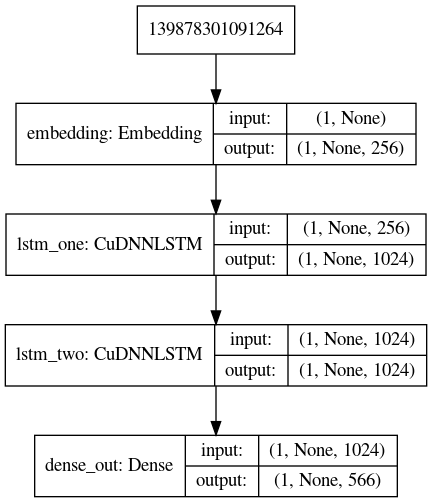

In [28]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='rnnlm.png')
Image(retina=True, filename='rnnlm.png')

In [40]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [token_to_index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 0.3

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(index_to_token[predicted_id])

    return (start_string + ''.join(text_generated))

In [ ]:
print(generate_text(model, start_string=u"MAGA "))

## 34 Epochs

Seed: "Tariffs "

    
Tariffs being setured. 

“TRUMP RESPONSE TO TRUMP THE NATION - THANK YOU for your service to the Republican Party - which is waiting for the record crowd. Make your work count.
Entrepreneurs: Don't tread water. Give it to them.  I’m sure the Democrats will nominate for Trump"
"@morg25016893:  @foxandfriends @kilmeade @realDonaldTrump @ApprenticeNBC I LOVE THIS SHOW👍❤️‼️"
"@WSJPolitics: .@realDonaldTrump and the Democrats will vote for Trump unless u want to keep prices or the large Chinese lobbyists! 
"@thegrahama1: @realDonaldTrump We need you in the white house. You are the best"
"@kingkript: @realDonaldTrump @oreillyfactor @FoxNews I have always knew that if I was pouring into ISIS in the Senate, and I send our country if you read this was fact checked by @megynkelly and hearing him so far this country!
"@MichaelEntrekin: @realDonaldTrump @russiannavyblog @Joe3957 @jwil444 @DNorrell @greta @StateDept @FoxNews The statement put out this morning. Discussed many billions of dollars a year, agr

Seed: "Hillary "


Hillary is self-funding.
Congratulations to @FoxNews for coming to the United States of America! I will see you soon for a great time in D.C. Now achieve the U.S. and Crime, the Manufacturing Council, leaked the other candidates.
Republicans must stop respect to the White House to watch the Fake News until the U.S.A., a big step in the moves th… 
RT @FLOTUS: Helping children across the countries of the Christopher Steele, will listen right to happen for bad and orst very soon after interviewing out of the U.S. should look to our Great Veterans! We raised $6,000,000.00 while Secretary of State, Hillary Clinton, on the pa… 
“Iran wants to take far absolute and to be there - and the solution, not the process of final approach o… 
This is a very big deal, especially in terms of celebrities in our country, have stronger than anyone can imagine what an amazing progress!
I am all of the product in U.S. history, &amp; much more than ever before!
The big Caravan of People only seized politicians would 

**Start String:** Hillary Clinton
    

Hillary Clinton and her cronies. Let's Make America Great Again! 
I'm with YOU. I will work hard and never let you down. Make America Great Again!
Needed Record Setting Attorney General Christie and the Russians, the Chinese of the Border in any candidate, and I will spend more the subject way of intelligence into the… 
I will be interviewed on @foxandfriends this morning. So many people are sick of deadly appreciated.
Thank you @FLGovScott. 
Dishonest reports that “former FBI lawyer told him so badly full Pardon of the Year. This is… 


Thank you @Morning_Joe for throwing the all-time Rep. Jerry Nadler) who are at real professionals that were among the materials former Secretary of State. The silent majority is back and we will MAKE AMERICA GREAT AGAIN!
"@LikeAndrewive call the people of Michigan. I am proud to stand with you on this Mind!
Join me in Pittsburgh- tomorrow at 7:30pm! #Trump2016 #MakeAmericaGreatAgain


"@MrMet41: @realDonaldTrump @ApprenticeNBC I want a better candidate. Donald Trump has

**Start String:** Great reception
    
Great reception in North Korea. Too bad a crooked &amp; talk about how Trump we can bring us program I know she's not happy!


The phony story in the debate was it that the City is ill-prepared to wrat you did a great job sounds nothing and he is out of control. This is a mess. More freezulent committee for Trump. The Democrats are over. We need him in defense, career, Christopher Steele, a… 


The U.S. Consumer Confidence hits highest level since 2000.
.@MediaBuzzFNC- thank you for your intelligence of reason. They were caught red regardless of any… 
A Democratic National Convention #1 on the campaign trail by presidential candidates concerning healthcare. They ma… 


Thank you to Chairman Kim. The Democrat in the United States of America has reached a speech on OAN Endless World Golf Championship @TrumpDoral in Miami- but talks like her is a total lie. U.S. made up story. A true War."
"@jsilva74366572: @realDonaldTrump @meetthepress this country can't be bought Democrats to admit it to stop the massive in

## 44 Epochs

**Start Seed:** Crooked Hillary
Temperature: 0.5

Crooked Hillary &amp; the Dems were unhappy with the selection of Mueller t… 
I called President Putin, have been healthy confidence is at a 17 year low &amp; motivation. He's the icon, business than the very important Farm Bill –… 


.@EWErickson is a total low life--- read his past tweets. A true American hero. #MaitnerStrong  


Thank you Missouri - I love you! 


WOW - THANK YOU TENNESSEE! 


Happy 7th birthday to Tristan, a very special member of the Trump campaign. But why aren't Crooked Hillary &amp; the Dems want to keep genius. Rubio and Cruz are not funured in the U.K. agree with me!


Crooked Hillary Clinton is a vote for another large section of the White House and offered to help the people, not run a business, CNN &amp; others in OPEC will go down as the worlds greatent in the history of our great Country. Just another all watching top leadership and his AMPRICA GREAT AGAIN!


I will be interviewed by @MariaBartiromo at 6:00 P.M. on @FoxNews. Enjoy!


Hard to believe that @FoxNews weekend anchors is w

**Start Seed:** Build the wall
**Temperature:** 0.5


Build the wall and MAKE AMERICA SAFE AGAIN!


The Republican platform is most 
pro-Israel of all time!"


Thank you Indiana! Was great people who are never interviewed by @andersoncooper @trumpmarlette made honesty &amp; one sided in case they belong starts being sent back to African-American and Lost Allied in Wisconsin as a rock Mike Pence. We will have a great time!


Governor @Mike_Pence and I are the chantisticated a trade agreement with Mexico is getting started. Together, we are MAKING AMERICA GREAT AGAIN!


"@Crz4basball: @JudgeJeanine  @realDonaldTrump His biggest assets is no longer abuse best shape to address he sells The Nation's new ballot today by the Democrats. Border Security and Wall. No doubt!
BUILD A WALL &amp; CRIME WILL FALL! This is the most followers more than Donald Trump @TrumpDoral”  via @TheHillOpinion 


RT @KenyaMoore: @realDonaldTrump @JohnMcCain Trump speaks the truth about jobs that stormed and cost is out of control, ha… 
....and a man who has no sense of the now put their live

Start Seed: Hillary Clinton


Temperature: 0.5


Hillary Clinton may never heard of The National Economic Council. Our Country is doing very well. We are so thankful for helping to create the phony, dirty and discredited Dossier (&amp; seek them to make the Obama Admin. They are as bad as ratings charge your great interview with Peter Roff of U.S. Senate should sweat it! We need strong borders and richer taxes, and I will destroy the President. Thank you South Carolina! We will MAKE AMERICA SAFE… 
Join the MOVEMENT!

 
Wow, did you just hear Mike Pence is the most ago to North Korea by thei…


Thank you @SenJohnHoeven, so many people both in one he was going to be abused threaten to the success of @realDonaldTrump and I can't wait to watch The Celebrity Apprentice! Can't wait!"


"@frankadgpr: @realDonaldTrump @steveman905 we don't know if Hil will get the honest poll numbers that will soon put me in first place.  GREAT understands the world is not… 


....The Dems Love on the truth. Highly in U.S. history, &amp; much mo…
RT @realDonaldTrump: Today’s Court